In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE, SMOTENC 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Scaled_Gilmore_Data_CT_SA_1_2.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Middle', 'ATP Label'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','ATP Middle', 'HYP Middle', 'ATP Label'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(137, 298)
(137, 1)


In [3]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[8])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Middle', 'ATP Label'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['HYP Label'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[1])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP Middle', 'HYP Middle', 'ATP Label'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(34, 298)
(34, 1)
<class 'pandas.core.frame.DataFrame'>


In [4]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(214, 298)
(214, 298)
(214, 298)
(216, 298)
(216, 298)
(216, 298)
(216, 298)
(216, 298)


In [5]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(214, 298)
(214, 298)
(214, 298)
(216, 298)
(216, 298)
(216, 298)
(216, 298)
(216, 298)
----------
(248, 298)
(248, 298)
(248, 298)
(250, 298)
(250, 298)
(250, 298)
(250, 298)
(250, 298)
Label shapes
(214, 1)
(214, 1)
(214, 1)
(216, 1)
(216, 1)
(216, 1)
(216, 1)
(216, 1)
----------
(248, 1)
(248, 1)
(248, 1)
(250, 1)
(250, 1)
(250, 1)
(250, 1)
(250, 1)


In [6]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [7]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.610920 using {'batch_size': 30, 'dropout': 0.2, 'epochs': 100, 'layer1_size': 100, 'layer2_size': 25}
D_in, H1, H2, D_out = 298, 100, 25, 1
EPOCHS = 100
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

test_size = 18
test_size1 = 17

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [8]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [9]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.load_state_dict(torch.load('./model_dict_hyp.pth'))
model.train()
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.load_state_dict(torch.load('./model_dict_hyp.pth'))
model1.train()
#print(model)
weights1 = torch.FloatTensor([5]) #Class weights?
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.load_state_dict(torch.load('./model_dict_hyp.pth'))
model2.train()
#print(model)
weights2 = torch.FloatTensor([5]) #Class weights?
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.load_state_dict(torch.load('./model_dict_hyp.pth'))
model3.train()
#print(model)
weights3 = torch.FloatTensor([5]) #Class weights?
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.load_state_dict(torch.load('./model_dict_hyp.pth'))
model4.train()
#print(model)
weights4 = torch.FloatTensor([5]) #Class weights?
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.load_state_dict(torch.load('./model_dict_hyp.pth'))
model5.train()
#print(model)
weights5 = torch.FloatTensor([5]) #Class weights?
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.load_state_dict(torch.load('./model_dict_hyp.pth'))
model6.train()
#print(model)
weights6 = torch.FloatTensor([5]) #Class weights?
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.load_state_dict(torch.load('./model_dict_hyp.pth'))
model7.train()
#print(model)
weights7 = torch.FloatTensor([5]) #Class weights?
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=298, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [11]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.88940 | Acc: 54.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.77291 | Acc: 52.556
Validation Accuracy |  33.33333333333333  PPV |  [0.83333333 0.08333333]  Recall |  [0.3125 0.5   ]
Training Epoch 003: | Loss: 1.25670 | Acc: 64.667
Validation Accuracy |  38.88888888888889  PPV |  [0.85714286 0.09090909]  Recall |  [0.375 0.5  ]
Training Epoch 004: | Loss: 1.15737 | Acc: 59.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  33.33333333333333  PPV |  [1.         0.14285714]  Recall |  [0.25 1.  ]
Training Epoch 005: | Loss: 1.05754 | Acc: 64.889
Validation Accuracy |  33.33333333333333  PPV |  [0.83333333 0.08333333]  Recall |  [0.3125 0.5   ]
Training Epoch 006: | Loss: 1.12231 | Acc: 66.000
Validation Accuracy |  38.88888888888889  PPV |  [1.         0.15384615]  Recall |  [0.3125 1.    ]
Training Epoch 007: | Loss: 1.01038 | Acc: 62.889
Validation Accuracy |  38.88888888888889  PPV |  [1.         0.15384615]  Recall |  [0.3125 1.    ]
Training Epoch 008: | Loss: 0.96289 | Acc: 69.889
Validation Accuracy |  33.33333333333333  PPV |  [0.83333333 0.08333333]  Recall |  [0.3125 0.5   ]
Training Epoch 009: | Loss: 0.97577 | Acc: 72.889
Validation Accuracy |  33.33333333333333  PPV |  [0.83333333 0.08333333]  Recall |  [0.3125 0.5   ]
Training Epoch 010: | Loss: 0.90779 | Acc: 71.778
Validation Accuracy |  33.33333333333333  PPV |  [0.83333333 0.08333333]  Recall |  [0.3125 0.5   ]
Trai

Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 061: | Loss: 0.10812 | Acc: 99.000
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 062: | Loss: 0.08216 | Acc: 98.222
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 063: | Loss: 0.07105 | Acc: 97.556
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 064: | Loss: 0.09286 | Acc: 99.000
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 065: | Loss: 0.08255 | Acc: 98.556
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 066: | Loss: 0.07101 | Acc: 99.333
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 067: | Loss: 0.07

In [12]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.00226 | Acc: 52.111
Validation Accuracy |  5.88235294117647  PPV |  [0.         0.05882353]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.93103 | Acc: 52.444
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.09090909]  Recall |  [0.375 1.   ]
Training Epoch 003: | Loss: 1.41312 | Acc: 63.333
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.08333333]  Recall |  [0.3125 1.    ]
Training Epoch 004: | Loss: 1.21872 | Acc: 63.889
Validation Accuracy |  17.647058823529413  PPV |  [1.         0.06666667]  Recall |  [0.125 1.   ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 005: | Loss: 1.15552 | Acc: 60.778
Validation Accuracy |  23.52941176470588  PPV |  [1.         0.07142857]  Recall |  [0.1875 1.    ]
Training Epoch 006: | Loss: 1.12967 | Acc: 63.556
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.07692308]  Recall |  [0.25 1.  ]
Training Epoch 007: | Loss: 1.14135 | Acc: 61.444
Validation Accuracy |  17.647058823529413  PPV |  [1.         0.06666667]  Recall |  [0.125 1.   ]
Training Epoch 008: | Loss: 1.03524 | Acc: 66.556
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.09090909]  Recall |  [0.375 1.   ]
Training Epoch 009: | Loss: 1.00010 | Acc: 69.111
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.09090909]  Recall |  [0.375 1.   ]
Training Epoch 010: | Loss: 1.01410 | Acc: 65.889
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.08333333]  Recall |  [0.3125 1.    ]
Training Epoch 011: | Loss: 0.92956 | Acc: 68.778
Validation Accuracy |  52.94117647058824  PPV |  [1.     

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 024: | Loss: 0.48161 | Acc: 90.000
Validation Accuracy |  88.23529411764706  PPV |  [0.9375 0.    ]  Recall |  [0.9375 0.    ]
Training Epoch 025: | Loss: 0.46319 | Acc: 86.778
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 026: | Loss: 0.43247 | Acc: 89.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 027: | Loss: 0.40793 | Acc: 88.778
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 028: | Loss: 0.34142 | Acc: 92.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 029: | Loss: 0.39625 | Acc: 90.111
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 030: | Loss: 0.39878 | Acc: 91.333
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 031: | Loss: 0.30532 | Acc: 90.000
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 032: | Loss: 0.29980 | Acc: 92.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 033: | Loss: 0.26612 | Acc: 91.778
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 034: | Loss: 0.27916 | Acc: 93.778
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 035: | Loss: 0.37539 | Acc: 90.889
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 036: | Loss: 0.26468 | Acc: 90.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 037: | Loss: 0.24837 | Acc: 94.333
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 038: | Loss: 0.23411 | Acc: 93.889


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 039: | Loss: 0.23318 | Acc: 94.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 040: | Loss: 0.27879 | Acc: 90.778
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 041: | Loss: 0.25021 | Acc: 93.444


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 042: | Loss: 0.20964 | Acc: 95.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 043: | Loss: 0.20085 | Acc: 92.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 044: | Loss: 0.21784 | Acc: 92.111
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 045: | Loss: 0.13708 | Acc: 96.000
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 046: | Loss: 0.15136 | Acc: 95.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 047: | Loss: 0.14816 | Acc: 97.444
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 048: | Loss: 0.14996 | Acc: 96.000
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 049: | Loss: 0.12423 | Acc: 97.444
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 050: | Loss: 0.16876 | Acc: 95.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 051: | Loss: 0.13114 | Acc: 96.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 052: | Loss: 0.12631 | Acc: 97.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 053: | Loss: 0.15007 | Acc: 94.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 054: | Loss: 0.12856 | Acc: 96.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 055: | Loss: 0.11337 | Acc: 96.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 056: | Loss: 0.11002 | Acc: 97.889
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 057: | Loss: 0.13227 | Acc: 95.444


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 058: | Loss: 0.10562 | Acc: 98.111
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 059: | Loss: 0.09824 | Acc: 99.000
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 060: | Loss: 0.09173 | Acc: 97.778


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 061: | Loss: 0.10209 | Acc: 98.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 062: | Loss: 0.11293 | Acc: 97.444
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 063: | Loss: 0.08700 | Acc: 98.111


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 064: | Loss: 0.08159 | Acc: 98.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 065: | Loss: 0.08455 | Acc: 98.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 066: | Loss: 0.10225 | Acc: 97.889
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 067: | Loss: 0.12593 | Acc: 98.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 068: | Loss: 0.11185 | Acc: 96.889
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 069: | Loss: 0.09427 | Acc: 97.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 070: | Loss: 0.06073 | Acc: 98.889
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 071: | Loss: 0.08003 | Acc: 98.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 072: | Loss: 0.07921 | Acc: 96.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 073: | Loss: 0.07487 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 074: | Loss: 0.06385 | Acc: 98.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 075: | Loss: 0.05354 | Acc: 98.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 076: | Loss: 0.05992 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 077: | Loss: 0.07064 | Acc: 98.111
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 078: | Loss: 0.06268 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 079: | Loss: 0.05028 | Acc: 99.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 080: | Loss: 0.06963 | Acc: 98.111
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 081: | Loss: 0.04441 | Acc: 99.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 082: | Loss: 0.09220 | Acc: 97.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 083: | Loss: 0.06305 | Acc: 99.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 084: | Loss: 0.07381 | Acc: 99.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 085: | Loss: 0.09683 | Acc: 96.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 086: | Loss: 0.08312 | Acc: 98.889
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 087: | Loss: 0.06335 | Acc: 98.333
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 088: | Loss: 0.04073 | Acc: 100.000
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 089: | Loss: 0.05681 | Acc: 99.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 090: | Loss: 0.05974 | Acc: 98.556
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 091: | Loss: 0.04601 | Acc: 99.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 092: | Loss: 0.03966 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 093: | Loss: 0.04863 | Acc: 99.000
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 094: | Loss: 0.05435 | Acc: 99.000
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 095: | Loss: 0.05346 | Acc: 98.222
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 096: | Loss: 0.03996 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 097: | Loss: 0.04795 | Acc: 99.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.23529411764706  PPV |  [0.9375 0.    ]  Recall |  [0.9375 0.    ]
Training Epoch 098: | Loss: 0.05552 | Acc: 98.111
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 099: | Loss: 0.04627 | Acc: 99.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 100: | Loss: 0.03610 | Acc: 99.667
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.71550 | Acc: 60.778
Validation Accuracy |  23.52941176470588  PPV |  [1.         0.07142857]  Recall |  [0.1875 1.    ]
Training Epoch 002: | Loss: 1.57553 | Acc: 57.000
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.09090909]  Recall |  [0.375 1.   ]
Training Epoch 003: | Loss: 1.27059 | Acc: 62.667
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.09090909]  Recall |  [0.375 1.   ]
Training Epoch 004: | Loss: 1.16367 | Acc: 62.889
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.08333333]  Recall |  [0.3125 1.    ]
Training Epoch 005: | Loss: 1.02999 | Acc: 64.667
Validation Accuracy |  52.94117647058824  PPV |  [0.9 0. ]  Recall |  [0.5625 0.    ]
Training Epoch 006: | Loss: 1.06521 | Acc: 65.333
Validation Accuracy |  35.294117647058826  PPV |  [0.85714286 0.        ]  Recall |  [0.375 0.   ]
Training Epoch 007: | Loss: 0.91391 | Acc: 71.889
Validation Accuracy |  47.05882352941176  PPV |  [0.88888889 0.     

Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 060: | Loss: 0.08822 | Acc: 98.556
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 061: | Loss: 0.12565 | Acc: 96.000
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 062: | Loss: 0.08188 | Acc: 97.778
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 063: | Loss: 0.07926 | Acc: 98.889
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 064: | Loss: 0.09752 | Acc: 98.222
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 065: | Loss: 0.08652 | Acc: 98.889
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 075: | Loss: 0.05945 | Acc: 99.000
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 076: | Loss: 0.06056 | Acc: 99.333
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 077: | Loss: 0.05769 | Acc: 99.333
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 078: | Loss: 0.07081 | Acc: 99.222
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 079: | Loss: 0.05404 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 080: | Loss: 0.06839 | Acc: 98.556
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 086: | Loss: 0.04281 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 087: | Loss: 0.06995 | Acc: 97.111
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 088: | Loss: 0.06546 | Acc: 99.000
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 089: | Loss: 0.05181 | Acc: 98.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 090: | Loss: 0.04146 | Acc: 99.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 091: | Loss: 0.04239 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 092: | Loss: 0.03659 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 093: | Loss: 0.03501 | Acc: 100.000
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 094: | Loss: 0.03104 | Acc: 100.000
Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]
Training Epoch 095: | Loss: 0.03503 | Acc: 100.000
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 096: | Loss: 0.06950 | Acc: 99.333
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 097: | Loss: 0.04166 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 098: | Loss: 0.04897 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 099: | Loss: 0.03834 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]
Training Epoch 100: | Loss: 0.04191 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]


In [14]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.45554 | Acc: 49.333
Validation Accuracy |  17.647058823529413  PPV |  [1.    0.125]  Recall |  [0.06666667 1.        ]
Training Epoch 002: | Loss: 1.82684 | Acc: 49.778
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.15384615]  Recall |  [0.26666667 1.        ]
Training Epoch 003: | Loss: 1.43875 | Acc: 61.444
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.15384615]  Recall |  [0.26666667 1.        ]
Training Epoch 004: | Loss: 1.23679 | Acc: 60.667
Validation Accuracy |  17.647058823529413  PPV |  [1.    0.125]  Recall |  [0.06666667 1.        ]
Training Epoch 005: | Loss: 1.13842 | Acc: 61.000
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 006: | Loss: 1.09296 | Acc: 65.889
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 007: | Loss: 1.10030 | Acc: 65.556
Validation Accuracy |  29.411764705882355  P

Training Epoch 056: | Loss: 0.11246 | Acc: 97.444
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 057: | Loss: 0.12508 | Acc: 97.444
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 058: | Loss: 0.09100 | Acc: 98.222
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 059: | Loss: 0.15264 | Acc: 99.000
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 060: | Loss: 0.13038 | Acc: 96.667
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 061: | Loss: 0.08099 | Acc: 98.556
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 062: | Loss: 0.09574 | Acc: 98.667
Va

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.61977 | Acc: 50.444
Validation Accuracy |  11.76470588235294  PPV |  [0.         0.11764706]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 2.05894 | Acc: 49.556
Validation Accuracy |  23.52941176470588  PPV |  [1.         0.13333333]  Recall |  [0.13333333 1.        ]
Training Epoch 003: | Loss: 1.65531 | Acc: 58.222
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 004: | Loss: 1.29245 | Acc: 56.556


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.76470588235294  PPV |  [0.         0.11764706]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.24169 | Acc: 53.333
Validation Accuracy |  11.76470588235294  PPV |  [0.         0.11764706]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.17928 | Acc: 60.111
Validation Accuracy |  23.52941176470588  PPV |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1.         0.13333333]  Recall |  [0.13333333 1.        ]
Training Epoch 007: | Loss: 1.14354 | Acc: 58.111
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 008: | Loss: 1.18291 | Acc: 60.000
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 009: | Loss: 1.03908 | Acc: 64.000
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 010: | Loss: 1.03749 | Acc: 68.111
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 011: | Loss: 1.02475 | Acc: 68.444
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 012: | Loss: 0.91534 | Acc: 68.111
Validation Accuracy |  23.52941176470588  PPV |  [1.         0.13333333]  Recall |  [0.13333333 1.        ]
Training Epoch 013: | Loss: 0.86902 | Acc: 73.000
Validati

Training Epoch 060: | Loss: 0.13211 | Acc: 97.556
Validation Accuracy |  82.35294117647058  PPV |  [0.92857143 0.33333333]  Recall |  [0.86666667 0.5       ]
Training Epoch 061: | Loss: 0.09307 | Acc: 96.667
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 062: | Loss: 0.07974 | Acc: 99.333
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 063: | Loss: 0.07717 | Acc: 97.889
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 064: | Loss: 0.07861 | Acc: 97.889
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 065: | Loss: 0.06040 | Acc: 99.333
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 066: | Loss: 0.06816 | Acc: 98.667
Va

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 099: | Loss: 0.02400 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 100: | Loss: 0.03562 | Acc: 99.222
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]


In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.76732 | Acc: 55.222
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 002: | Loss: 1.65599 | Acc: 50.667
Validation Accuracy |  58.82352941176471  PPV |  [0.9        0.14285714]  Recall |  [0.6 0.5]
Training Epoch 003: | Loss: 1.39964 | Acc: 64.444
Validation Accuracy |  58.82352941176471  PPV |  [0.9        0.14285714]  Recall |  [0.6 0.5]
Training Epoch 004: | Loss: 1.28722 | Acc: 60.333
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.15384615]  Recall |  [0.26666667 1.        ]
Training Epoch 005: | Loss: 1.17169 | Acc: 60.111
Validation Accuracy |  41.17647058823529  PPV |  [0.85714286 0.1       ]  Recall |  [0.4 0.5]
Training Epoch 006: | Loss: 1.11309 | Acc: 65.111
Validation Accuracy |  58.82352941176471  PPV |  [0.9        0.14285714]  Recall |  [0.6 0.5]
Training Epoch 007: | Loss: 0.99427 | Acc: 69.000
Validation Accuracy |  58.82352941176471  PPV |  [0.83333333 0.       

Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 057: | Loss: 0.07515 | Acc: 99.333
Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 058: | Loss: 0.08125 | Acc: 97.889
Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 059: | Loss: 0.07135 | Acc: 99.000
Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 060: | Loss: 0.07767 | Acc: 99.000
Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 061: | Loss: 0.07726 | Acc: 97.889
Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 062: | Loss: 0.07808 | Acc: 99.000
Validation Accuracy |  64.70588235294117  PPV |  [0.

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.25065 | Acc: 50.333
Validation Accuracy |  17.647058823529413  PPV |  [1.    0.125]  Recall |  [0.06666667 1.        ]
Training Epoch 002: | Loss: 1.74010 | Acc: 51.556
Validation Accuracy |  47.05882352941176  PPV |  [1.         0.18181818]  Recall |  [0.4 1. ]
Training Epoch 003: | Loss: 1.55162 | Acc: 58.222
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.15384615]  Recall |  [0.26666667 1.        ]
Training Epoch 004: | Loss: 1.35669 | Acc: 55.556
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 005: | Loss: 1.18606 | Acc: 62.333
Validation Accuracy |  47.05882352941176  PPV |  [1.         0.18181818]  Recall |  [0.4 1. ]
Training Epoch 006: | Loss: 1.13375 | Acc: 66.889
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.16666667]  Recall |  [0.33333333 1.        ]
Training Epoch 007: | Loss: 1.09270 | Acc: 63.222
Validation Accuracy |  41.17647058823529  PPV |  [1

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 056: | Loss: 0.08038 | Acc: 99.222
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 057: | Loss: 0.11404 | Acc: 97.333
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 058: | Loss: 0.09674 | Acc: 97.556
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 059: | Loss: 0.09429 | Acc: 98.444
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 060: | Loss: 0.09339 | Acc: 97.333
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 061: | Loss: 0.09528 | Acc: 98.444
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 062: | Loss: 0.07756 | Acc: 99.333
Validation Accuracy |  8

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  82.35294117647058  PPV |  [0.875 0.   ]  Recall |  [0.93333333 0.        ]
Training Epoch 082: | Loss: 0.05199 | Acc: 99.667
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 083: | Loss: 0.03791 | Acc: 99.667
Validation Accuracy |  82.35294117647058  PPV |  [0.875 0.   ]  Recall |  [0.93333333 0.        ]
Training Epoch 084: | Loss: 0.05999 | Acc: 99.333
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 085: | Loss: 0.03655 | Acc: 99.667
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 086: | Loss: 0.06455 | Acc: 99.333
Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 087: | Loss: 0.03644 | Acc: 99.333
Validation Accuracy |  82.35294117647058  PPV |  [0.875 0.   ]  Recall |

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.06039 | Acc: 55.889
Validation Accuracy |  17.647058823529413  PPV |  [1.    0.125]  Recall |  [0.06666667 1.        ]
Training Epoch 002: | Loss: 1.97213 | Acc: 47.444
Validation Accuracy |  23.52941176470588  PPV |  [1.         0.13333333]  Recall |  [0.13333333 1.        ]
Training Epoch 003: | Loss: 1.41361 | Acc: 61.111
Validation Accuracy |  41.17647058823529  PPV |  [0.85714286 0.1       ]  Recall |  [0.4 0.5]
Training Epoch 004: | Loss: 1.27955 | Acc: 62.111
Validation Accuracy |  17.647058823529413  PPV |  [0.66666667 0.07142857]  Recall |  [0.13333333 0.5       ]
Training Epoch 005: | Loss: 1.14593 | Acc: 60.222
Validation Accuracy |  17.647058823529413  PPV |  [0.66666667 0.07142857]  Recall |  [0.13333333 0.5       ]
Training Epoch 006: | Loss: 1.18605 | Acc: 62.667
Validation Accuracy |  23.52941176470588  PPV |  [0.75       0.07692308]  Recall |  [0.2 0.5]
Training Epoch 007: | Loss: 1.10686 | Acc: 65.222
Validation Accuracy |  23.52941176470

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 041: | Loss: 0.14421 | Acc: 97.778
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 042: | Loss: 0.15832 | Acc: 96.778
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 043: | Loss: 0.13837 | Acc: 96.000
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 044: | Loss: 0.15607 | Acc: 98.556
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 045: | Loss: 0.13725 | Acc: 96.333
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 046: | Loss: 0.11084 | Acc: 96.778
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 047: | Loss: 0.12867 | Acc: 97.889
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 048: | Loss: 0.10457 | Acc: 98.22

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.23529411764706  PPV |  [0.88235294 0.        ]  Recall |  [1. 0.]
Training Epoch 056: | Loss: 0.07913 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 057: | Loss: 0.09891 | Acc: 97.889
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 058: | Loss: 0.10172 | Acc: 98.556
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 059: | Loss: 0.07600 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 060: | Loss: 0.08677 | Acc: 98.222
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 061: | Loss: 0.07562 | Acc: 98.667
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 062: | Loss: 0.09433 | Acc: 99.000
Validation Accuracy |  94.11764705882352  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 074: | Loss: 0.07056 | Acc: 99.000
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 075: | Loss: 0.05461 | Acc: 99.333
Validation Accuracy |  88.23529411764706  PPV |  [0.88235294 0.        ]  Recall |  [1. 0.]
Training Epoch 076: | Loss: 0.05660 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 077: | Loss: 0.04198 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 078: | Loss: 0.05780 | Acc: 99.000
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 079: | Loss: 0.07651 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 080: | Loss: 0.05611 | Acc: 98.222
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 081: | Loss: 0.04844 | Acc:

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]
Training Epoch 094: | Loss: 0.05093 | Acc: 99.667
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 095: | Loss: 0.04420 | Acc: 99.667
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 096: | Loss: 0.05407 | Acc: 98.889
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 097: | Loss: 0.04670 | Acc: 99.333
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 098: | Loss: 0.06232 | Acc: 98.889
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 099: | Loss: 0.03180 | Acc: 99.667
Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]
Training Epoch 100: | Loss: 0.03648 | Acc: 99.667
Validation Accuracy |  94.11764705882352  PPV | 

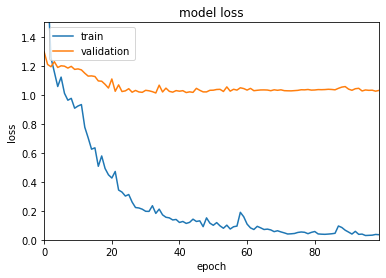

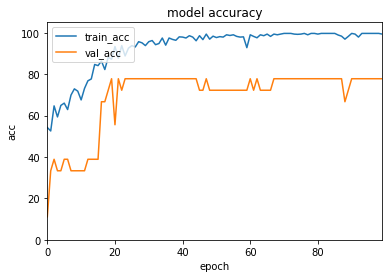

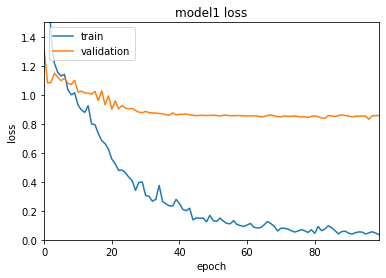

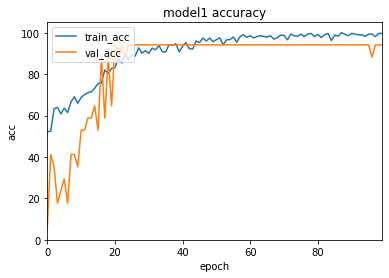

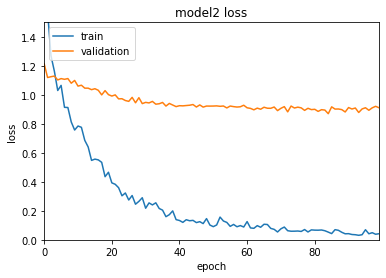

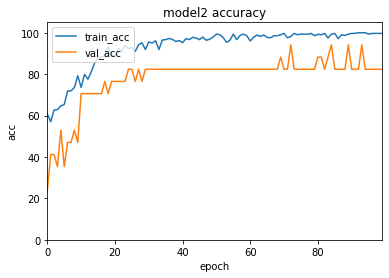

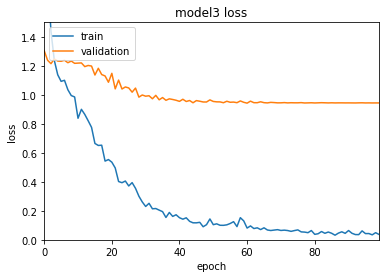

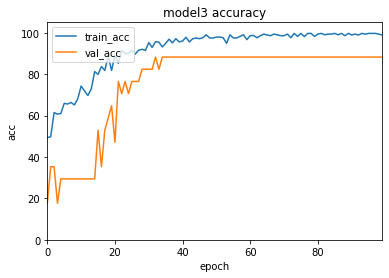

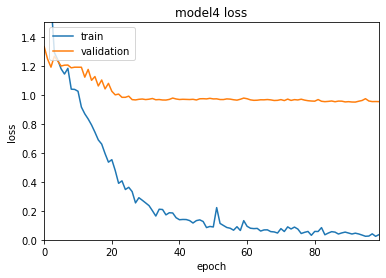

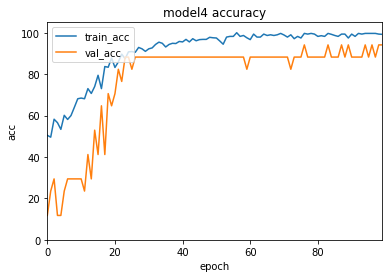

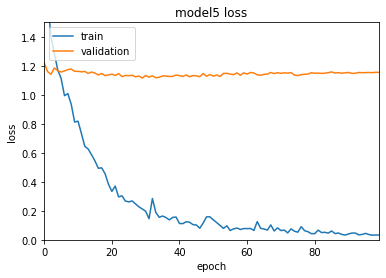

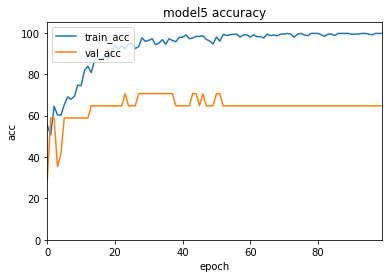

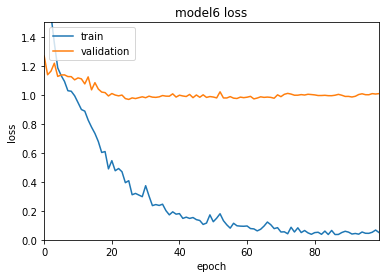

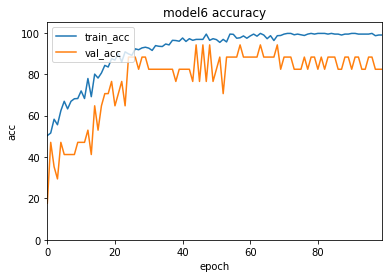

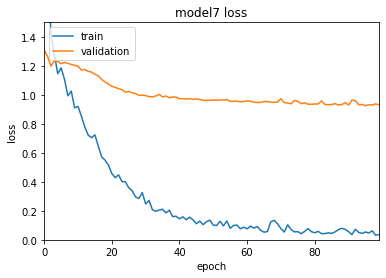

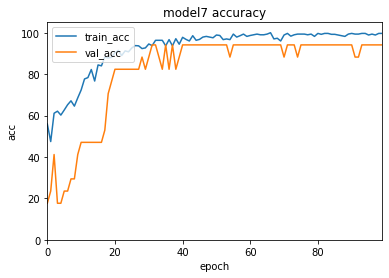

In [19]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]


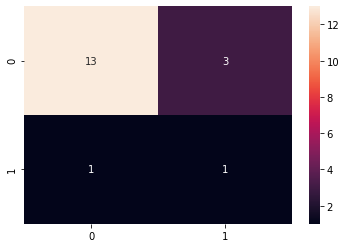

In [20]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  94.11764705882352  PPV |  [0.94117647 0.        ]  Recall |  [1. 0.]


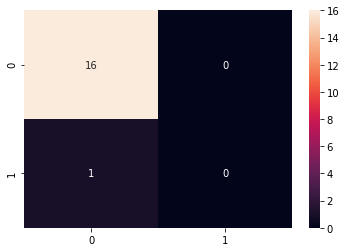

In [21]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  82.35294117647058  PPV |  [0.93333333 0.        ]  Recall |  [0.875 0.   ]


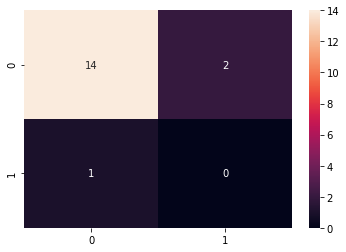

In [22]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  88.23529411764706  PPV |  [0.93333333 0.5       ]  Recall |  [0.93333333 0.5       ]


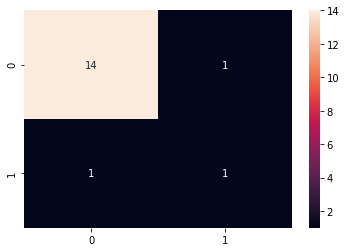

In [23]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]


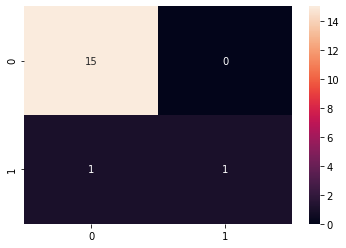

In [24]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]


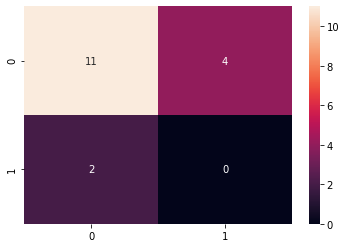

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  82.35294117647058  PPV |  [0.875 0.   ]  Recall |  [0.93333333 0.        ]


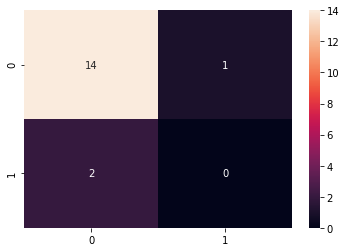

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  94.11764705882352  PPV |  [0.9375 1.    ]  Recall |  [1.  0.5]


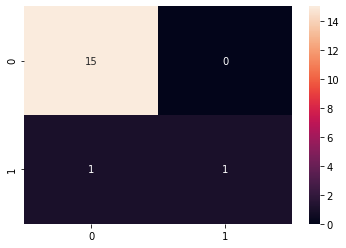

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [28]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

[[112  11]
 [ 10   4]]
Positive Predictive Value tp/(tp+fp):  0.26666666666666666
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.8467153284671532
Recall Value tp/(tp+fn):  0.2857142857142857


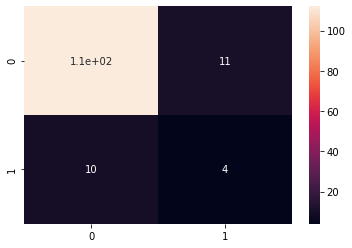

In [29]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 

In [30]:
#Line up Subjects by case number based on test_index in skf. This is done before smoting.
#Allows us to later check t-score to see if the models improve when using imputed data
#that we are able to classify the ones that have borderline t-scores (60 - 65 ish)
#Can create a histogram of the distribution based on correctly predicted vs incorrectly predicted

#Try the HYP Hyperparameters and pretraining on the ATP models - Significantly better
#Double check whether or not grid search included interpolated samples - No, but I did smote them.
#Could try and add twins into the testing/validation set - Need to rescale them and find the minmax scaling file I used later.

In [31]:
Twin_Validation = pd.ExcelFile("Scaled Twin CTSA1y with labels sex GA.xlsx") #298 Features, CT1y SA1y GA Sex
Twin_Labels = pd.ExcelFile("Twin Labels.xlsx") #Labels for twins

twin_data = Twin_Validation.parse(Twin_Validation.sheet_names[0])
twin_label_data = Twin_Labels.parse(Twin_Labels.sheet_names[0])
twin_data_features = twin_data.loc[:, twin_data.columns]
twin_data_features = twin_data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Middle', 'ATP Label'], axis=1)
twin_data_features = twin_data_features.dropna()
twin_data_features = twin_data_features.drop(['HYP Label'], axis=1)
twin_labels = twin_label_data.loc[:, twin_label_data.columns]
twin_labels = twin_labels.drop(['ROI','ATP Middle', 'HYP Middle', 'ATP Label'], axis=1)
twin_labels = twin_labels.dropna()
print(twin_data_features.shape)
print(twin_labels.shape)

(142, 298)
(142, 1)


In [32]:
type(twin_data_features) #Currently dataframe, needs to be numpy array
td_features = twin_data_features.to_numpy()
td_data = testData(torch.FloatTensor(td_features))

t_labels = twin_labels.to_numpy()

Validation Accuracy |  74.64788732394366  PPV |  [0.89565217 0.11111111]  Recall |  [0.81102362 0.2       ]
[[103  24]
 [ 12   3]]


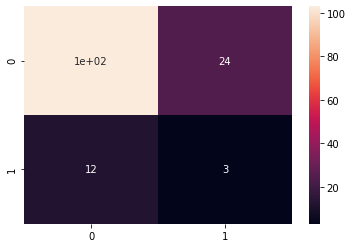

In [33]:
y_pred_list = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(t_labels, y_pred_list)
ppv = precision_score(t_labels, y_pred_list, average=None)
recall = recall_score(t_labels, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  74.64788732394366  PPV |  [0.89565217 0.11111111]  Recall |  [0.81102362 0.2       ]
[[103  24]
 [ 12   3]]


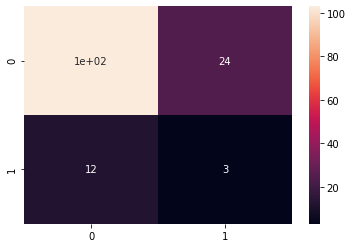

In [34]:
y_pred_list1 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list1.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list1 = [a.squeeze().tolist() for a in y_pred_list1]
accuracy = accuracy_score(t_labels, y_pred_list1)
ppv = precision_score(t_labels, y_pred_list1, average=None)
recall = recall_score(t_labels, y_pred_list1, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list1)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  72.53521126760563  PPV |  [0.89285714 0.1       ]  Recall |  [0.78740157 0.2       ]
[[100  27]
 [ 12   3]]


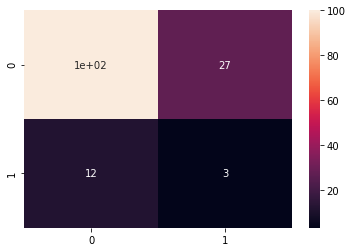

In [35]:
y_pred_list2 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list2.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list2 = [a.squeeze().tolist() for a in y_pred_list2]
accuracy = accuracy_score(t_labels, y_pred_list2)
ppv = precision_score(t_labels, y_pred_list2, average=None)
recall = recall_score(t_labels, y_pred_list2, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list2)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  74.64788732394366  PPV |  [0.88888889 0.08      ]  Recall |  [0.81889764 0.13333333]
[[104  23]
 [ 13   2]]


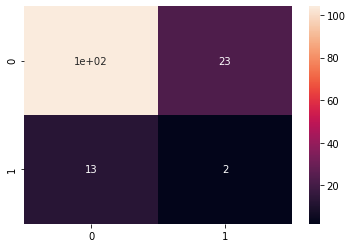

In [36]:
y_pred_list3 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list3.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list3 = [a.squeeze().tolist() for a in y_pred_list3]
accuracy = accuracy_score(t_labels, y_pred_list3)
ppv = precision_score(t_labels, y_pred_list3, average=None)
recall = recall_score(t_labels, y_pred_list3, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list3)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  80.28169014084507  PPV |  [0.90243902 0.15789474]  Recall |  [0.87401575 0.2       ]
[[111  16]
 [ 12   3]]


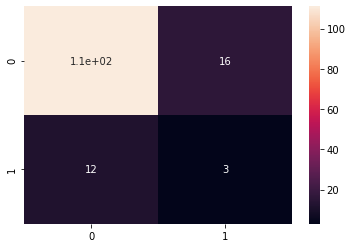

In [37]:
y_pred_list4 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list4.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list4 = [a.squeeze().tolist() for a in y_pred_list4]
accuracy = accuracy_score(t_labels, y_pred_list4)
ppv = precision_score(t_labels, y_pred_list4, average=None)
recall = recall_score(t_labels, y_pred_list4, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list4)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  72.53521126760563  PPV |  [0.9   0.125]  Recall |  [0.77952756 0.26666667]
[[99 28]
 [11  4]]


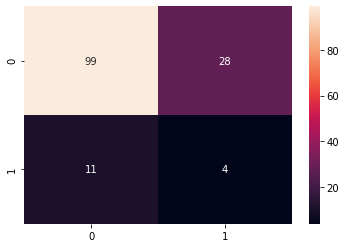

In [38]:
y_pred_list5 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list5.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list5 = [a.squeeze().tolist() for a in y_pred_list5]
accuracy = accuracy_score(t_labels, y_pred_list5)
ppv = precision_score(t_labels, y_pred_list5, average=None)
recall = recall_score(t_labels, y_pred_list5, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list5)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  76.76056338028168  PPV |  [0.89830508 0.125     ]  Recall |  [0.83464567 0.2       ]
[[106  21]
 [ 12   3]]


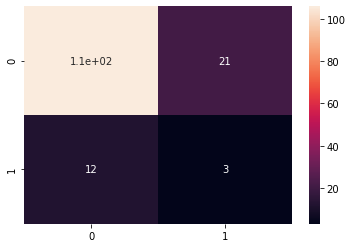

In [39]:
y_pred_list6 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list6.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list6 = [a.squeeze().tolist() for a in y_pred_list6]
accuracy = accuracy_score(t_labels, y_pred_list6)
ppv = precision_score(t_labels, y_pred_list6, average=None)
recall = recall_score(t_labels, y_pred_list6, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list6)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  77.46478873239437  PPV |  [0.89915966 0.13043478]  Recall |  [0.84251969 0.2       ]
[[107  20]
 [ 12   3]]


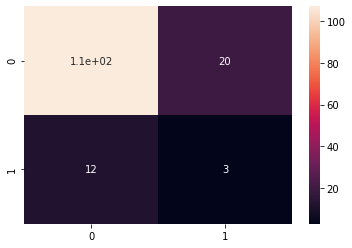

In [40]:
y_pred_list7 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list7.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list7 = [a.squeeze().tolist() for a in y_pred_list7]
accuracy = accuracy_score(t_labels, y_pred_list7)
ppv = precision_score(t_labels, y_pred_list7, average=None)
recall = recall_score(t_labels, y_pred_list7, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list7)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

In [41]:
final_twin_pred = []
for x in range(0,142):
    count = 0
    if(y_pred_list[x] == 1.0):
        count += 1
    if(y_pred_list1[x] == 1.0):
        count += 1
    if(y_pred_list2[x] == 1.0):
        count += 1
    if(y_pred_list3[x] == 1.0):
        count += 1
    if(y_pred_list4[x] == 1.0):
        count += 1
    if(y_pred_list5[x] == 1.0):
        count += 1
    if(y_pred_list6[x] == 1.0):
        count += 1
    if(y_pred_list7[x] == 1.0):
        count += 1
    if(count > 4):
        final_twin_pred.append(1.0)
    else:
        final_twin_pred.append(0.0)

print(final_twin_pred)

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


Validation Accuracy |  76.05633802816901  PPV |  [0.8974359 0.12     ]  Recall |  [0.82677165 0.2       ]
[[105  22]
 [ 12   3]]


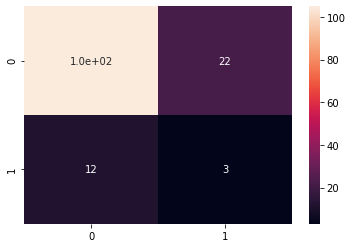

In [42]:
accuracy = accuracy_score(t_labels, final_twin_pred)
ppv = precision_score(t_labels, final_twin_pred, average=None)
recall = recall_score(t_labels, final_twin_pred, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, final_twin_pred)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)